# Octopus Energy Agile Wholesale Price Monitoring

In [1]:
import pandas as pd
from changepoint_online import NPFocus
import numpy as np
from plotnine import *

## Data from Octopus Energy

We import some data downloaded from Octopus Energy’s [Agile
Portal](https://agile.octopushome.net/historical-data)

In [2]:
agile_hist = pd.read_csv("data/agile-half-hour-actual-rates-01-01-2023_28-02-2024.csv")

# Prepping data for analysis
agile_hist['time'] = pd.to_datetime(agile_hist['Period from'], format="%d/%m/%Y %H:%M")
df_hist = agile_hist.rename(columns={"Agile Import price (p/kWh)": "value"})
df_hist['is_peak'] = df_hist['time'].dt.hour.isin(range(16, 19)).replace({True: 'yes', False: 'no'}).astype('category')
df_hist['value'] = pd.to_numeric(df_hist['value'], errors='coerce')

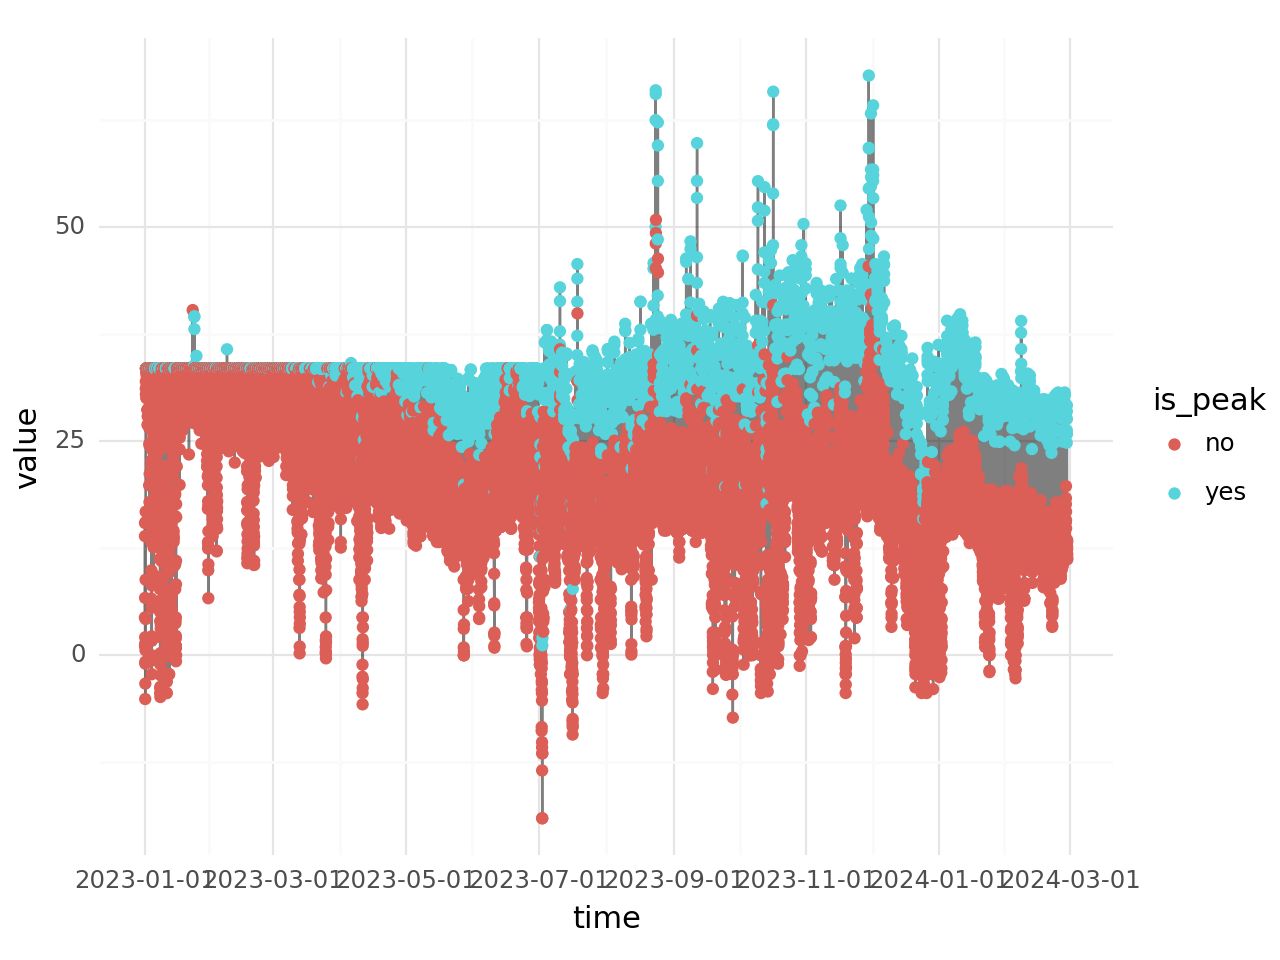

In [3]:
# Plotting the data
(ggplot(df_hist, aes(x='time', y='value')) +
 geom_line(alpha=0.5) +
 geom_point(aes(color='is_peak')) +
 theme_minimal()
)

In [4]:
from pandas.tseries.offsets import DateOffset


# Subtracting the median by hour
training_day = df_hist['time'].min() + DateOffset(days=60)
df_hist['hour'] = df_hist['time'].dt.hour
hour_median = df_hist[df_hist['time'] <= training_day].groupby('hour')['value'].median().rename('med')
df_hist = df_hist.join(hour_median, on='hour')
df_hist['y_adjusted'] = df_hist['value'] - df_hist['med']

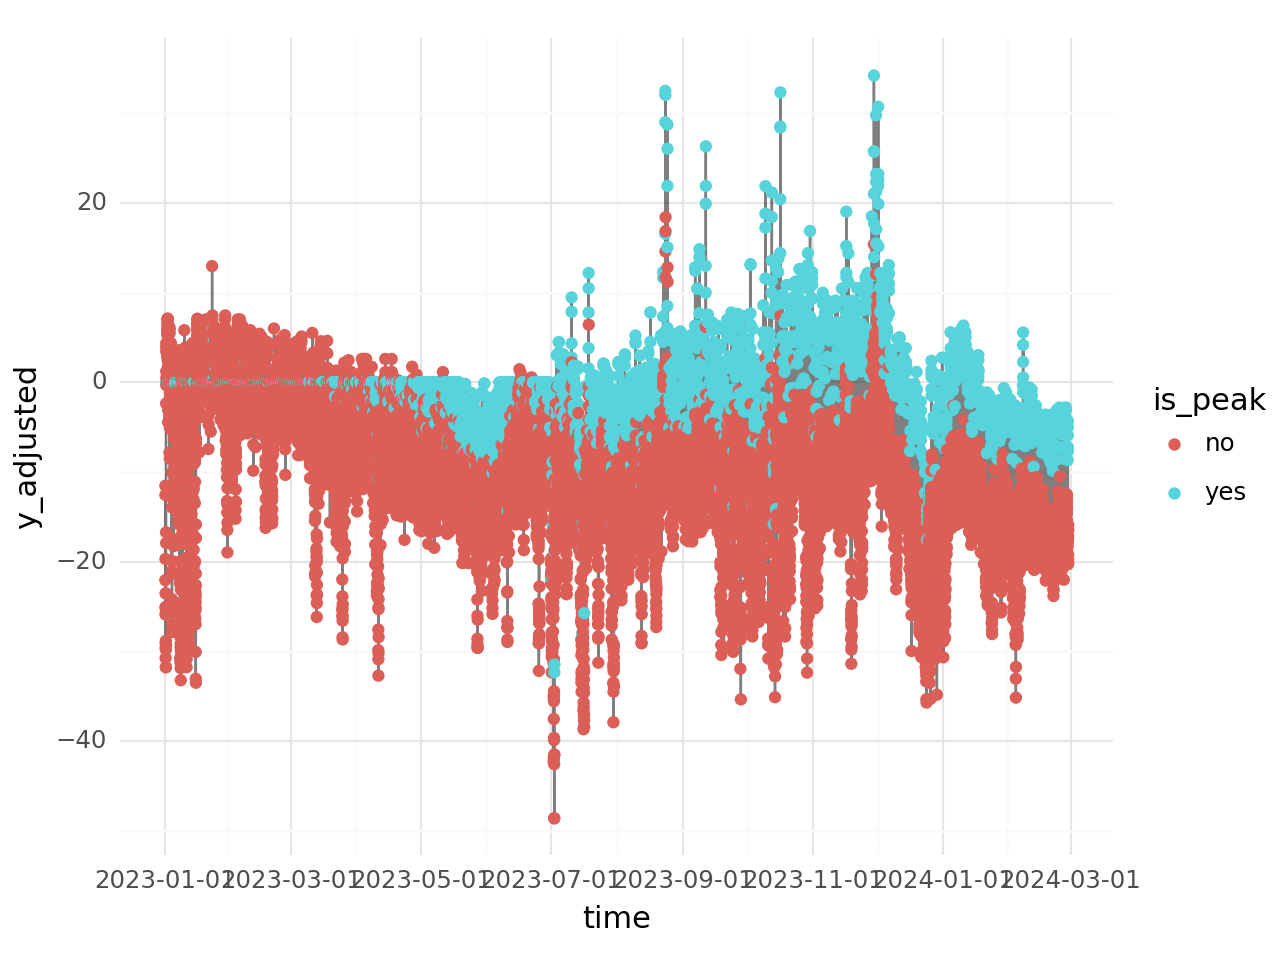

In [5]:
# Plotting the adjusted data
(ggplot(df_hist, aes(x='time', y='y_adjusted')) +
 geom_line(alpha=0.5) +
 geom_point(aes(color='is_peak')) +
 theme_minimal()
)

In [6]:
df_train = df_hist.query("time <= @training_day")
df_test = df_hist.query("time > @training_day")

# Creating some quantiles for the NPFocus detector
quantiles = [np.quantile(df_train.y_adjusted, q) for q in [.5, 0.75]]

# monitoring only up changes (e.g. increases in price)
detector = NPFocus(quantiles, side = "left")
threshold = 15
 
# Simulate data stream
for y in df_test.y_adjusted:
    detector.update(y)
    changepoint_info = detector.changepoint()
    if changepoint_info["max_stat"] > threshold:
        # Changepoint detected!
        break
 
# Access changepoint information
stopping_time = changepoint_info["stopping_time"]
changepoint = changepoint_info["changepoint"]

In [7]:
detection_plot = (
ggplot(df_test) +
  aes(x = "time", y = "value") +
  geom_line(alpha = .5) +
  geom_vline(xintercept = df_test.iloc[changepoint].time, linetype = "dotted") +
  geom_vline(xintercept = df_test.iloc[stopping_time].time)
)
ofgems_price_cap = pd.Timestamp('2023-07-01 00:00:00')
time_delta = df_test.iloc[stopping_time].time - ofgems_price_cap

Interestingly enough, if we look from the plot above we notice that we
detect a change in the upper tail. This was about 91 hours following the
[lift of the energy
cap](https://www.theguardian.com/business/2023/may/25/britain-energy-price-cap-cut-ofgem-electricity-gas-bills-how-changes-affect-you)
that happened on the 1 July in the UK. If we see more in details what
happened following the rise of the energy cap:

/home/romano/Documents/changepoint.online/.venv/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 17034 rows containing missing values.

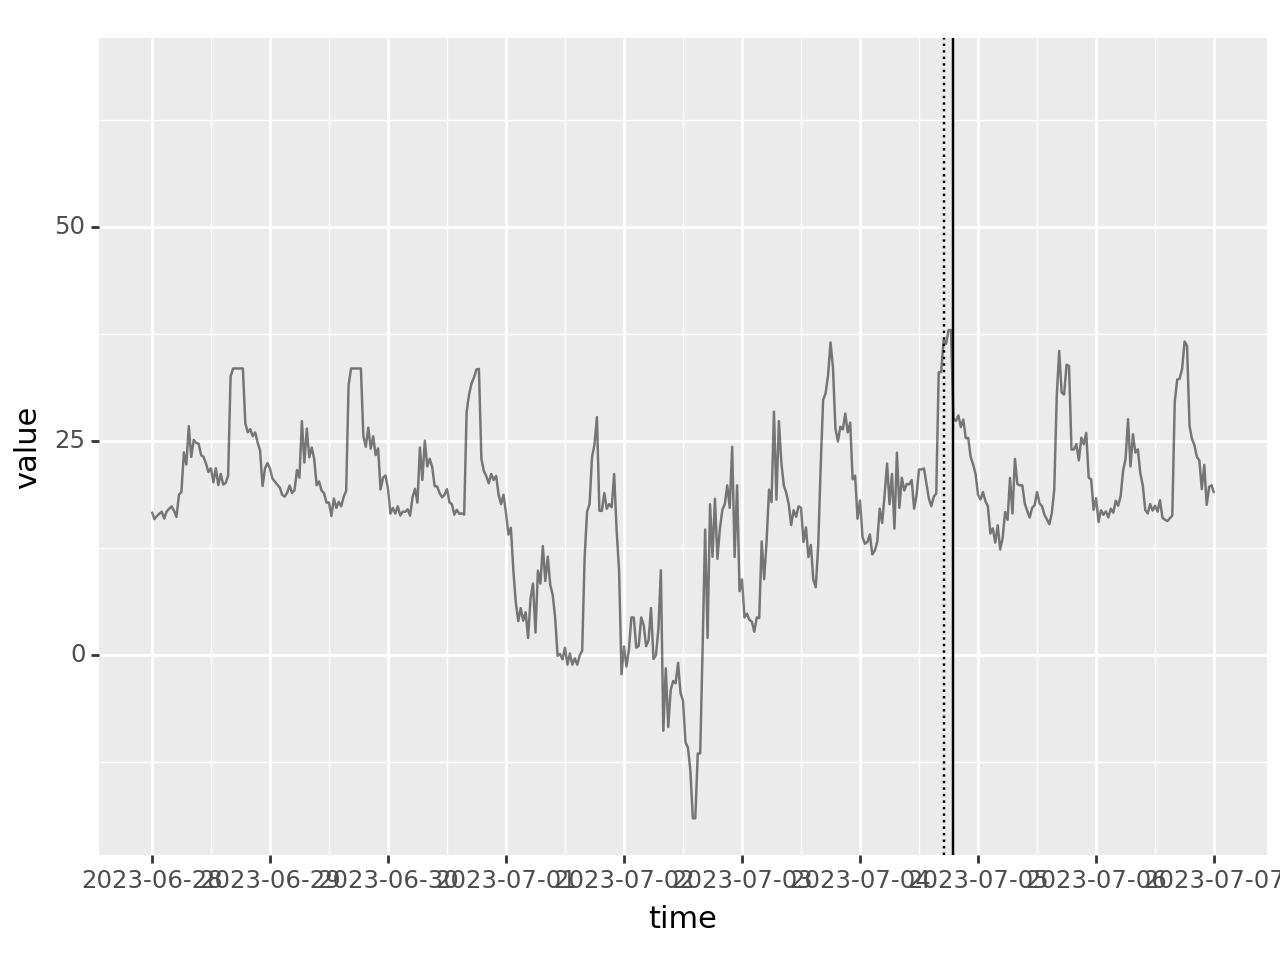

In [8]:
(detection_plot + xlim(pd.Timestamp('2023-06-28 00:00:00'), pd.Timestamp('2023-07-07')))

We can see that NPFOCuS detected an increase in one of the upper tail of
the distribution. One case see clearly that there was a sudden drop in
price for the first two days, however the prices slightly increased over
peak times.